In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import numpy as np
import sklearn
from sklearn.pipeline import Pipeline
import statsmodels.api as sm
import time
import tensorflow as tf
from tensorflow import keras

In [2]:
plt.rcParams['figure.figsize'] = (16.0, 12.0)

# Import of data and creation of split

In [3]:
df = pd.read_csv('housing.csv')

In [4]:
train, test = sklearn.model_selection.train_test_split(df, test_size=0.2, random_state=42)
train = train.reset_index(drop=True)
test = test.reset_index(drop=True)

def XYsplit(df):
    tdf = df.copy(deep=True)
    return tdf.drop(['house_value'], axis=1, inplace=False), tdf['house_value']

In [5]:
X_train, y_train = XYsplit(train)
print(f"{X_train.shape}")
print(f"{y_train.shape}")
X_test, y_test = XYsplit(test)
print(f"{X_test.shape}")
print(f"{y_test.shape}")
X_data, y_data = XYsplit(df)

(404, 5)
(404,)
(101, 5)
(101,)


In [6]:
X_train

,crime_rate,avg_number_of_rooms,distance_to_employment_centers,property_tax_rate,pupil_teacher_ratio
0,0.10153,6.279,4.0522,398.0,18.7
1,9.96654,6.485,1.9784,666.0,20.2
2,1.05393,5.935,4.4986,307.0,21.0
3,0.30347,6.312,5.4159,287.0,19.6
4,8.15174,5.390,1.7281,666.0,20.2
5,1.25179,5.570,3.7979,307.0,21.0
6,0.19186,6.431,5.4159,287.0,19.6
7,0.03961,6.037,5.9853,224.0,20.2
8,0.01432,6.816,8.3248,256.0,15.1
9,0.05497,5.985,4.8122,224.0,20.2


# Functions

In [7]:
def trunc_df(df):
    tdf = df.copy(deep=True)
    return tdf[tdf['house_value'] != 50.0]

In [8]:
def df_transform(df):
    tdf = df.copy(deep=True)
    tdf['crime_rate'] = np.log(tdf['crime_rate'])
    return tdf

In [9]:
class ModelClass():
    def __init__(self, train, full=True, transformed=True, truncate=True, n=5, i=100):
        t1 = time.time()
        tdf = train.copy(deep=True)
        if full is True:
            model = Pipeline([('PCA', sklearn.decomposition.PCA()),
                              ('poly', sklearn.preprocessing.PolynomialFeatures(n)),
                              ('linear', sklearn.linear_model.ElasticNetCV(l1_ratio=[x/i for x in range(1,i)],
                                                                           normalize=True,
                                                                           max_iter=100000,
                                                                           #cv=sklearn.model_selection.LeaveOneOut(),
                                                                           cv=5,
                                                                           n_jobs=-2,
                                                                           )
                              )
                             ])
        else:
            model = sklearn.linear_model.LinearRegression()
        if transformed is True:
            tdf = df_transform(tdf)
        else:
            pass
        if truncate is True:
            train_df = trunc_df(tdf)
        else:
            train_df = tdf
        print(f"Total training set: {train_df.shape}")
        X, y = XYsplit(train_df)
        model.fit(X=X, y=y)
        print(f"Fitted! Internal R^2: {model.score(X=X, y=y)}")
        print(f"Internal: if truncated, then score is only without values including 50.0")
        self.train = train
        self.full = full
        self.transformed = transformed
        self.truncate = truncate
        self.model = model
        print(f"Elapsed time: {time.time()-t1}")
        return None
    
    def test(self, test, graph=False):
        X_test, y_test = XYsplit(test)
        y_pred = self.model.predict(X_test)
        #y_pred = np.where(y_pred < 0, 0, y_pred)
        if self.truncate is True:
            y_pred = np.where(y_pred > 50.0, 50.0, y_pred)
        print(f"MSE: {sklearn.metrics.mean_squared_error(y_pred, y_test)}")
        print(f"MAE: {sklearn.metrics.mean_absolute_error(y_pred, y_test)}")
        if graph is True:
            plt.figure(figsize=(16, 24))
            plt.subplot(2,1,1)
            sns.regplot(x=y_pred, y=y_test, fit_reg=True)
            plt.subplot(2,1,2)
            sns.distplot(y_test-y_pred, fit=stats.norm)
            plt.show()
        return (sklearn.metrics.mean_squared_error(y_pred, y_test),
                sklearn.metrics.mean_absolute_error(y_pred, y_test),
                np.std(y_test-y_pred))

# Test of linear regression models

Total training set: (389, 6)
Fitted! Internal R^2: 0.84103843414342
Internal: if truncated, then score is only without values including 50.0
Elapsed time: 116.40831470489502
MSE: 136.38285040685528
MAE: 6.817104163917716


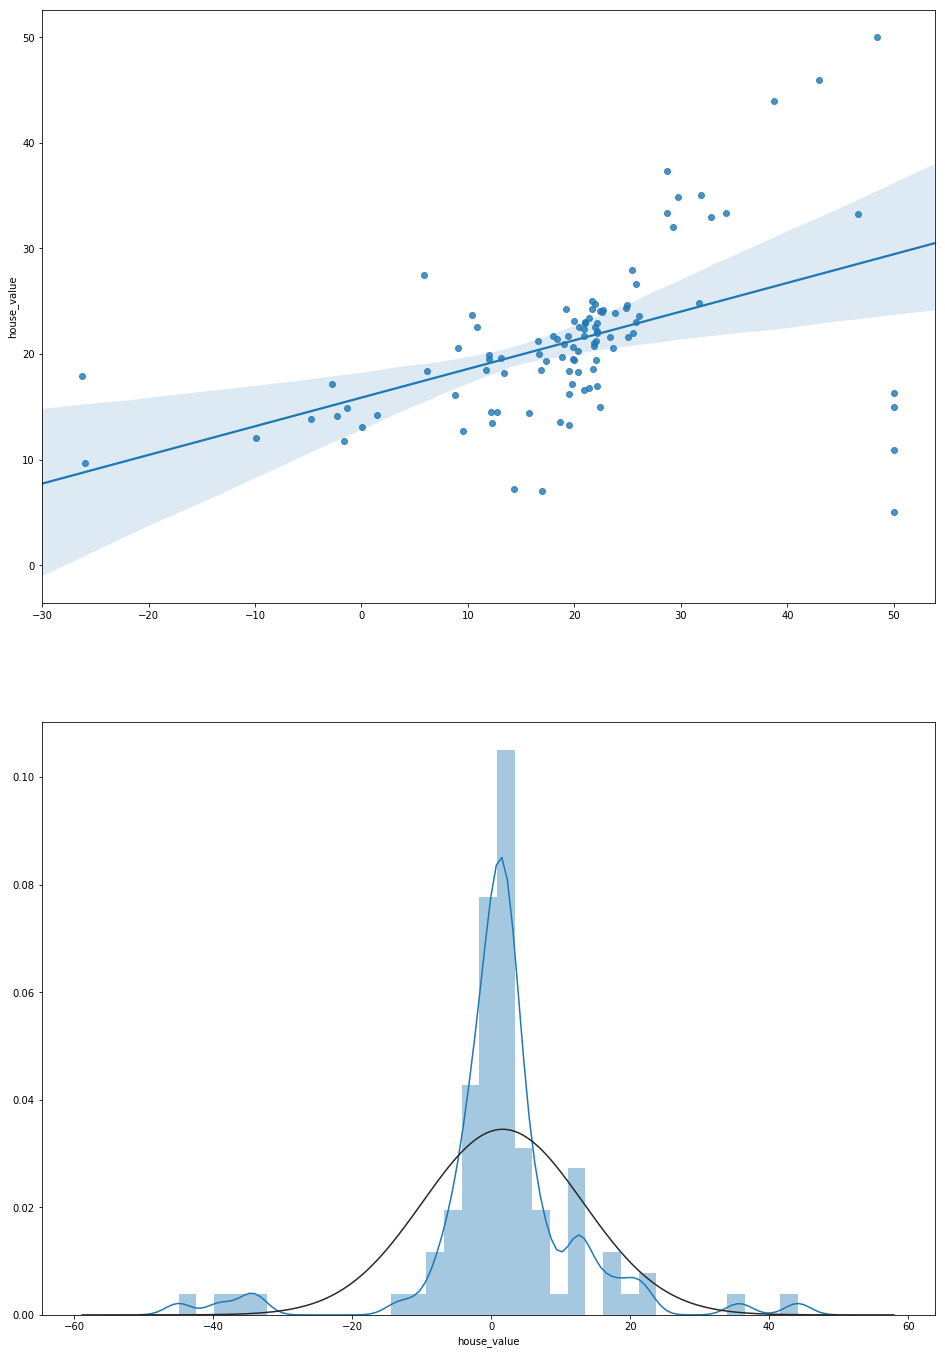

(136.38285040685528, 6.817104163917716, 11.56066442890349)

In [10]:
BestLinear = ModelClass(train)
BestLinear.test(test, graph=True)

In [11]:
print(f"ElasticNetCV alpha: {BestLinear.model.named_steps['linear'].alpha_}")
print(f"ElasticNetCV ratio: {BestLinear.model.named_steps['linear'].l1_ratio_}")
print(f"ElasticNetCV alphas: {BestLinear.model.named_steps['linear'].alphas_}")

ElasticNetCV alpha: 0.008328562423363687
ElasticNetCV ratio: 0.99
ElasticNetCV alphas: [[2.34828441e+01 2.19001790e+01 2.04241802e+01 ... 2.69995642e-02
  2.51798840e-02 2.34828441e-02]
 [1.17414220e+01 1.09500895e+01 1.02120901e+01 ... 1.34997821e-02
  1.25899420e-02 1.17414220e-02]
 [7.82761469e+00 7.30005966e+00 6.80806007e+00 ... 8.99985475e-03
  8.39329466e-03 7.82761469e-03]
 ...
 [2.42091176e-01 2.25775041e-01 2.10558559e-01 ... 2.78346023e-04
  2.59586433e-04 2.42091176e-04]
 [2.39620858e-01 2.23471214e-01 2.08410002e-01 ... 2.75505758e-04
  2.56937592e-04 2.39620858e-04]
 [2.37200445e-01 2.21213929e-01 2.06304851e-01 ... 2.72722871e-04
  2.54342262e-04 2.37200445e-04]]


Total training set: (404, 6)
Fitted! Internal R^2: 0.6157429916968773
Internal: if truncated, then score is only without values including 50.0
Elapsed time: 0.002794504165649414
MSE: 26.571903158027148
MAE: 3.5435643640497894


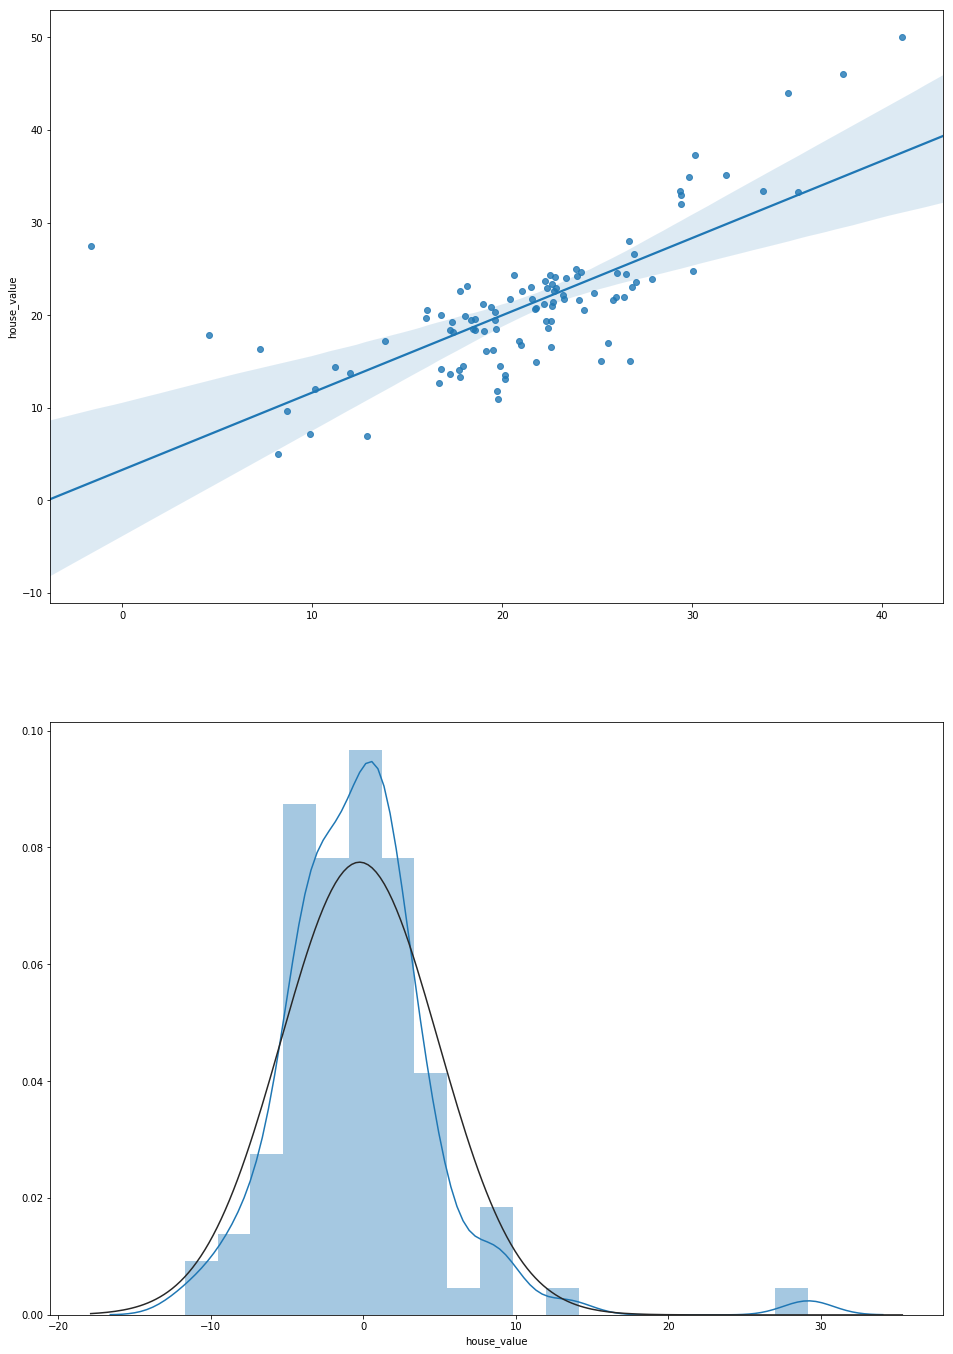

(26.571903158027148, 3.5435643640497894, 5.1488319175008375)

In [12]:
BasicLinear = ModelClass(train, full=False, truncate=False, transformed=False)
BasicLinear.test(test, graph=True)

In [13]:
range_results = []
start_time = time.time()
for i in range(8):
    temp = format(i, '03b')
    full = bool(int(temp[0]))
    truncate = bool(int(temp[1]))
    transformed = bool(int(temp[2]))
    print(full, truncate, transformed)
    model = ModelClass(train, full=full, truncate=truncate, transformed=transformed)
    MSE, MAE, SD = model.test(test)
    range_results.append((i, MSE, MAE, SD, model))
#print(results)
print(time.time()-start_time)

False False False
Total training set: (404, 6)
Fitted! Internal R^2: 0.6157429916968775
Internal: if truncated, then score is only without values including 50.0
Elapsed time: 0.0029833316802978516
MSE: 26.571903158026984
MAE: 3.543564364049777
False False True
Total training set: (404, 6)
Fitted! Internal R^2: 0.6113307270910968
Internal: if truncated, then score is only without values including 50.0
Elapsed time: 0.002530813217163086
MSE: 48.77551790977927
MAE: 4.450111554199827
False True False
Total training set: (389, 6)
Fitted! Internal R^2: 0.704063250128834
Internal: if truncated, then score is only without values including 50.0
Elapsed time: 0.002840280532836914
MSE: 24.932636822542598
MAE: 3.3993861320683822
False True True
Total training set: (389, 6)
Fitted! Internal R^2: 0.7040010742177024
Internal: if truncated, then score is only without values including 50.0
Elapsed time: 0.0029659271240234375
MSE: 49.56005156695027
MAE: 4.535667266642205
True False False
Total training 

In [14]:
results = pd.DataFrame([x[:-1] for x in range_results], columns=('index', 'MSE', 'MAE', 'SD'))
results

,index,MSE,MAE,SD
0,0,2.657190e+01,3.543564,5.148832
1,1,4.877552e+01,4.450112,6.359942
2,2,2.493264e+01,3.399386,4.986362
3,3,4.956005e+01,4.535667,6.259607
4,4,1.569933e+01,3.117939,3.856728
5,5,4.603218e+06,302.386558,2124.354703
6,6,1.156153e+01,2.695818,3.391205
7,7,1.363829e+02,6.817104,11.560664


Total training set: (389, 6)
Fitted! Internal R^2: 0.8131310978165056
Internal: if truncated, then score is only without values including 50.0
Elapsed time: 99.73679614067078
MSE: 11.561525188319104
MAE: 2.6958177479108376


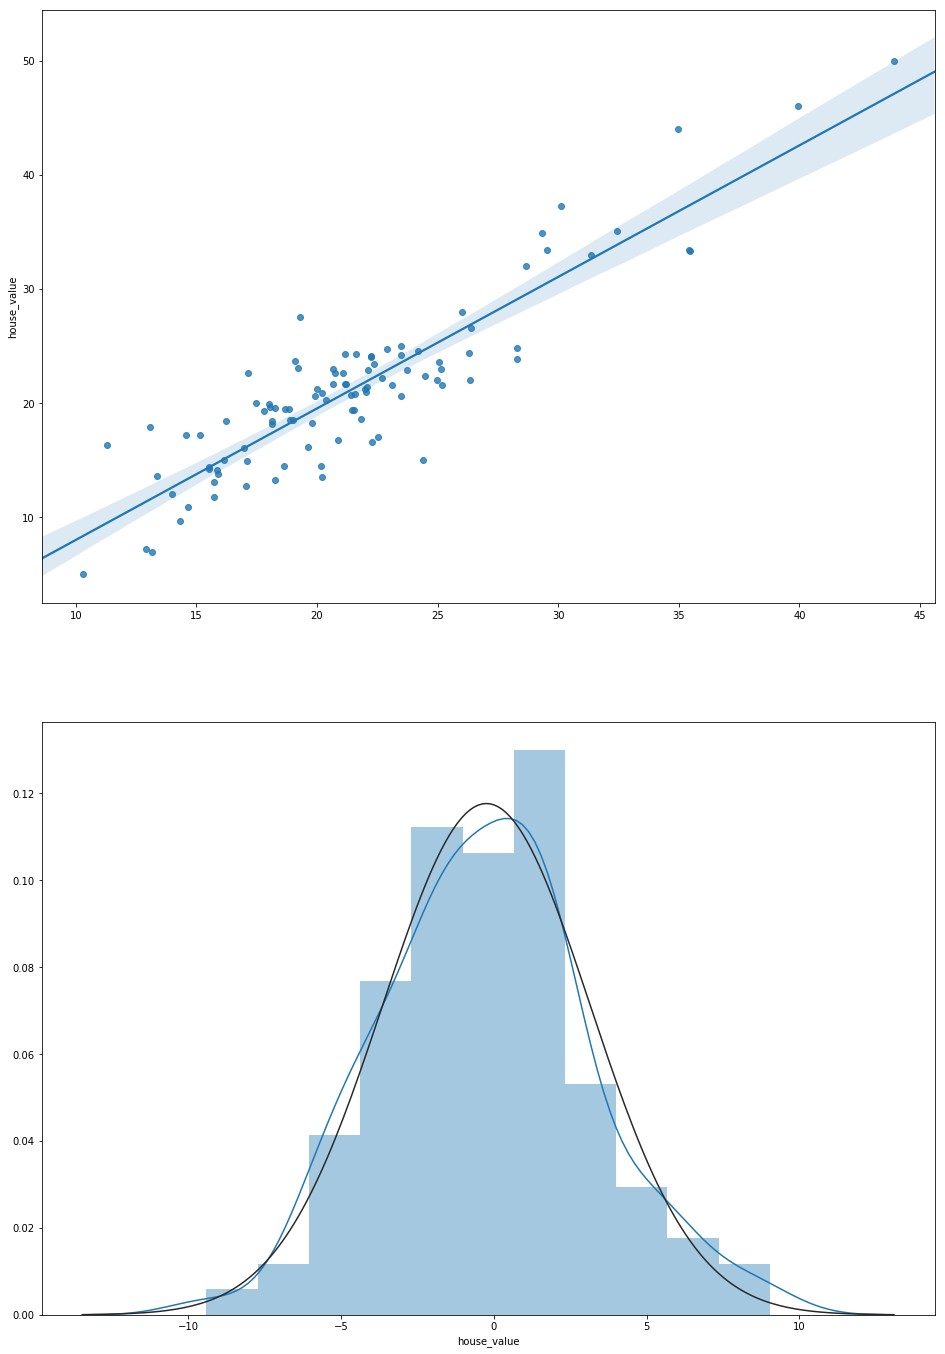

(11.561525188319104, 2.6958177479108376, 3.39120503759204)

In [15]:
BestModel = ModelClass(train, transformed=False)
BestModel.test(test, graph=True)

# NN models

In [16]:
def build_keras_model():
    # Basic model mimicking Tensorflow's https://www.tensorflow.org/tutorials/keras/basic_regression
    # as a reference point for performance with the full Boston housing dataset.
    model = keras.Sequential([
        keras.layers.Dense(64,
                          activation=tf.nn.relu,
                          input_shape=(X_train.shape[1],)
                          ),
        keras.layers.Dense(64,
                          activation=tf.nn.relu),
        keras.layers.Dense(1)
    ])
    
    optimizer = tf.train.RMSPropOptimizer(0.001)
    
    model.compile(loss='mse',
                 optimizer=optimizer,
                 metrics=['mae']
                 )
    
    return model

NNmodel_base = build_keras_model()
NNmodel_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                384       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 4,609
Trainable params: 4,609
Non-trainable params: 0
_________________________________________________________________


In [17]:
class Counter(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: print(epoch)

def plot_history(history):
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error [1000$]')
    plt.plot(history.epoch,
             np.array(history.history['mean_absolute_error']),
             label='Train Loss')
    plt.plot(history.epoch,
             np.array(history.history['val_mean_absolute_error']),
             label = 'Val loss')
    plt.legend()
    #plt.ylim([0, 5])

EPOCHS = 500

0
Testing set Mean Abs Error: $7993.99


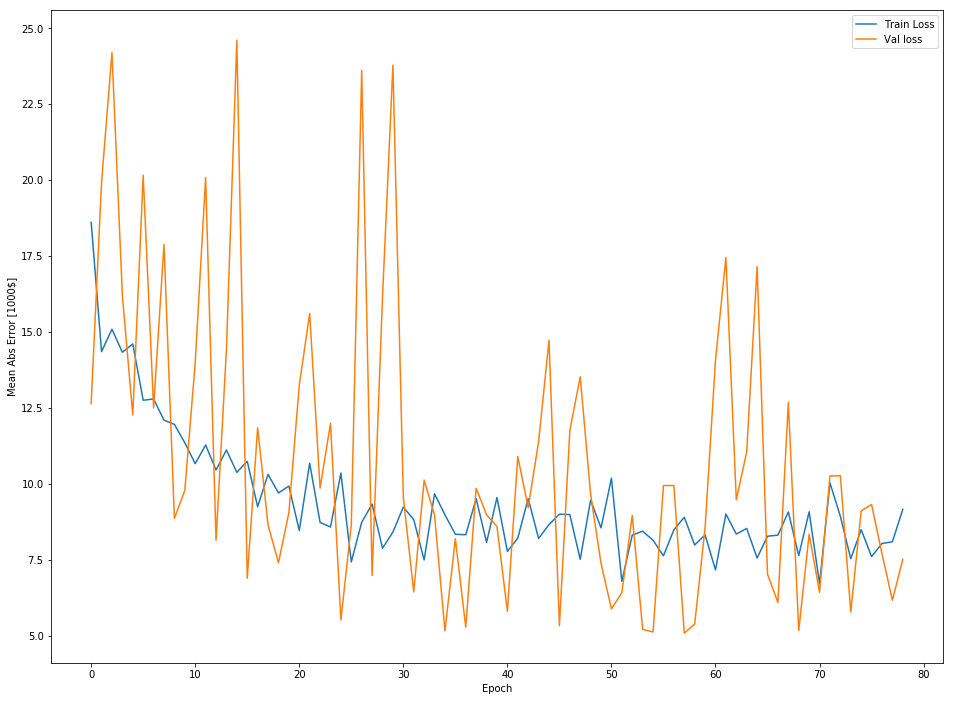

In [18]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

history = NNmodel_base.fit(X_train,
                           y_train,
                           epochs=EPOCHS,
                           validation_split=0.2,
                           verbose=0,
                           callbacks=[early_stop, Counter()]
                          )

plot_history(history)

[NNmodel_base_loss, NNmodel_base_mae] = NNmodel_base.evaluate(X_test, y_test, verbose=0)

print("Testing set Mean Abs Error: ${:7.2f}".format(NNmodel_base_mae * 1000))

Neural network model doesn't seem to do as well as the best linear model, and suffers from highly fluctuating validation error. 

# Stacking

In [19]:
column_names = [f"x{i}" for i in range(8)]
X_stack_train = pd.DataFrame(columns=column_names)
X_stack_test = pd.DataFrame(columns=column_names)
for i in range(8):
    model = range_results[i][-1]
    stack_train = model.model.predict(X_train)
    stack_test = model.model.predict(X_test)
    if model.truncate is True:
        stack_train = np.where(stack_train >= 50.0, 50.0, stack_train)
        stack_test = np.where(stack_test >= 50.0, 50.0, stack_test)
    X_stack_train[f"x{i}"] = stack_train
    X_stack_test[f"x{i}"] = stack_test

print(f"Shape of training dataset: {X_stack_train.shape}")
print(f"Shape of test dataset: {X_stack_test.shape}")

Shape of training dataset: (404, 8)
Shape of test dataset: (101, 8)


In [20]:
t1 = time.time()
#stack_model = Pipeline([('PCA', sklearn.decomposition.PCA()),
#                        ('poly', sklearn.preprocessing.PolynomialFeatures(7)),
#                        ('linear', sklearn.linear_model.ElasticNetCV(l1_ratio=[x/i for x in range(1,100)],
#                                                                     normalize=True,
#                                                                     max_iter=10000000,
#                                                                     #cv=sklearn.model_selection.LeaveOneOut(),
#                                                                     cv=5,
#                                                                     n_jobs=-2,
#                                                                     tol=.001
#                                                                    )
#                        )
#                        ])
stack_model = sklearn.linear_model.LinearRegression(normalize=True)
stack_model.fit(X=X_stack_train, y=y_train)
print(f"Fitted! Internal R^2: {stack_model.score(X=X_stack_train, y=y_train)}")
print(f"Training time: {time.time()-t1}")

Fitted! Internal R^2: 0.7141779661560823
Training time: 0.002079486846923828


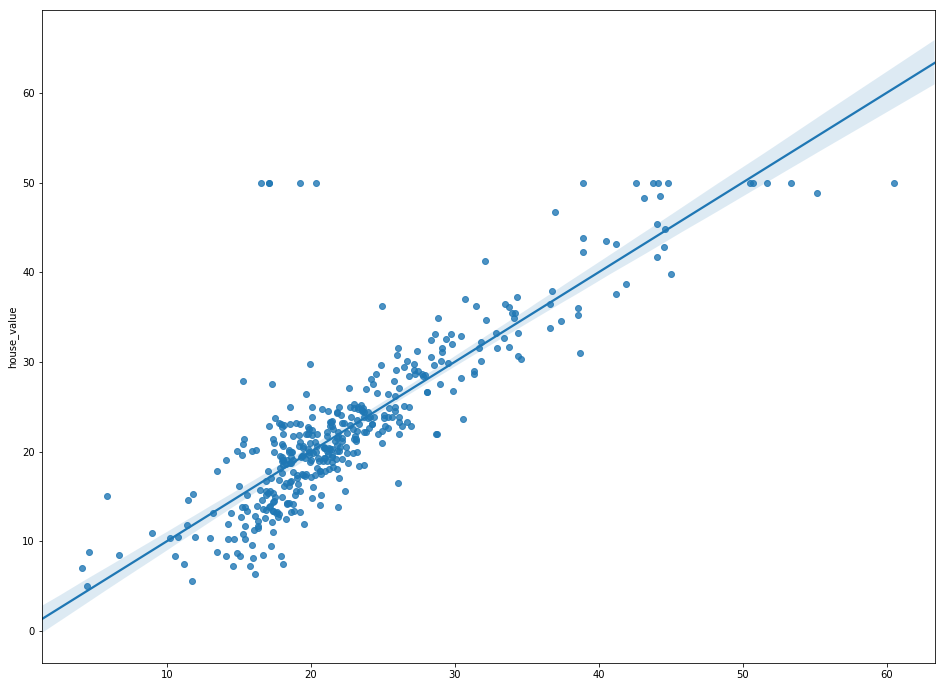

In [21]:
sns.regplot(x=stack_model.predict(X_stack_train), y=y_train, fit_reg=True)

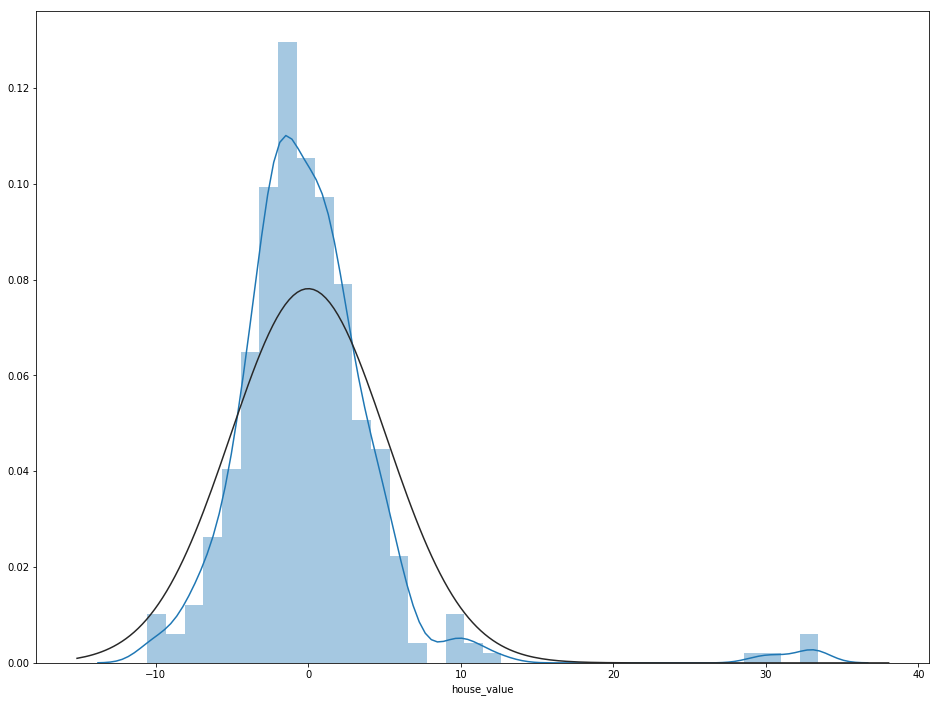

In [22]:
sns.distplot((y_train - stack_model.predict(X_stack_train)), fit=stats.norm)

In [23]:
y_stack_pred = stack_model.predict(X_stack_test)
y_stack_pred = np.where(y_stack_pred > 50.0, 50.0, y_stack_pred)
print(f"MSE: {sklearn.metrics.mean_squared_error(y_stack_pred, y_test)}")
print(f"MAE: {sklearn.metrics.mean_absolute_error(y_stack_pred, y_test)}")

MSE: 12.136060949380491
MAE: 2.8001319995199623


Still not comparable to just using results for the best model. However, the complete stacking methodology seems to be using the best model to train again on the results produced by each model. 

In [24]:
np.std(y_data - stack_model.predict(pd.concat([X_stack_train, X_stack_test])))

11.988242012277238

# Preparation of prediction for deployment

In [25]:
dataset_residuals = y_data - BestModel.model.predict(X_data)
BestModel_SD = np.std(dataset_residuals)
sklearn.externals.joblib.dump(BestModel.model, 'model.pkl')
sklearn.externals.joblib.dump(BestModel_SD, 'SD.pkl')

['SD.pkl']